In [ ]:
# import the required libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
df=pd.read_excel("/content/distbert_comments.xlsx")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21424 entries, 0 to 21423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21417 non-null  object
 1   label   21424 non-null  object
dtypes: object(2)
memory usage: 334.9+ KB


In [ ]:
df.head(10)

,text,label
0,dont remember the last time hindus crashed a p...,offensive
1,being a muslim it is our duty to tell you on i...,offensive
2,very good,not hate
3,all indian muslim go pakistan,offensive
4,so modi pushing for more children :child:,offensive
5,40 million hindus killed in bangladesh,not hate
6,he is telling what people want every politicia...,offensive
7,:salutingface: india,not hate
8,modi is not anti muslim pakistanis dont want u...,offensive
9,please :foldedhands: muslim leave india :facew...,not hate


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
# Initialize stop words
stop_words = set(stopwords.words('english'))

# Function to remove stop words
def remove_stopwords(text):
    if not isinstance(text, str):
        text = ""  # Convert non-string values to empty strings
    return ' '.join(word for word in text.split() if word.lower() not in stop_words)

# Apply the function to the 'text' column
df['text'] = df['text'].apply(remove_stopwords)

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatizing(data):
    # Ensure data is a string to avoid TypeError
    if isinstance(data, str):
        return " ".join([lemmatizer.lemmatize(word) for word in data.split()])
    return data  # Return the original data if it's not a string

df['text'] = df['text'].apply(lemmatizing)


In [ ]:
df.head()

,text,label
0,dont remember last time hindu crashed plane to...,offensive
1,muslim duty tell islam callled dakwah islam ch...,offensive
2,good,not hate
3,indian muslim go pakistan,offensive
4,modi pushing child :child:,offensive


<Axes: xlabel='label', ylabel='count'>

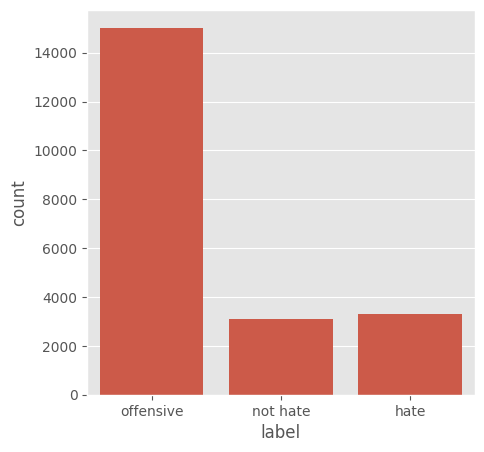

In [ ]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='label', data = df)

Text(0.5, 1.0, 'Distribution of sentiments')

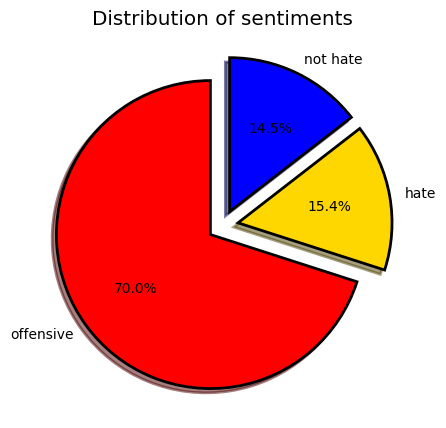

In [ ]:
fig = plt.figure(figsize=(5,5))
colors = ("red", "gold", "blue")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = df['label'].value_counts()
explode = (0.1, 0.1,0.1)
tags.plot(kind='pie',autopct = '%1.1f%%', shadow=True, colors = colors, startangle =90,
         wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

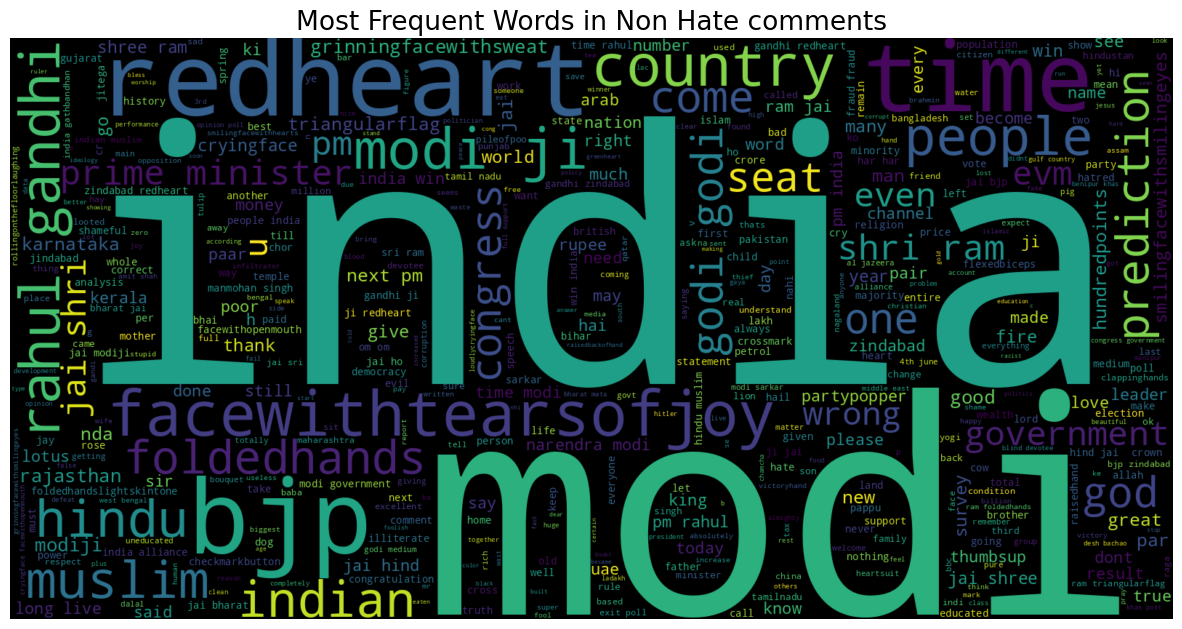

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Filter non-hate tweets
non_hate = df[df.label == 'not hate']

# Join all non-hate tweet texts into a single string, ensuring only strings are included
text = ' '.join([str(word) for word in non_hate['text'] if isinstance(word, str)])

# Generate the word cloud
plt.figure(figsize=(15, 15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Non Hate comments', fontsize=19)
plt.show()


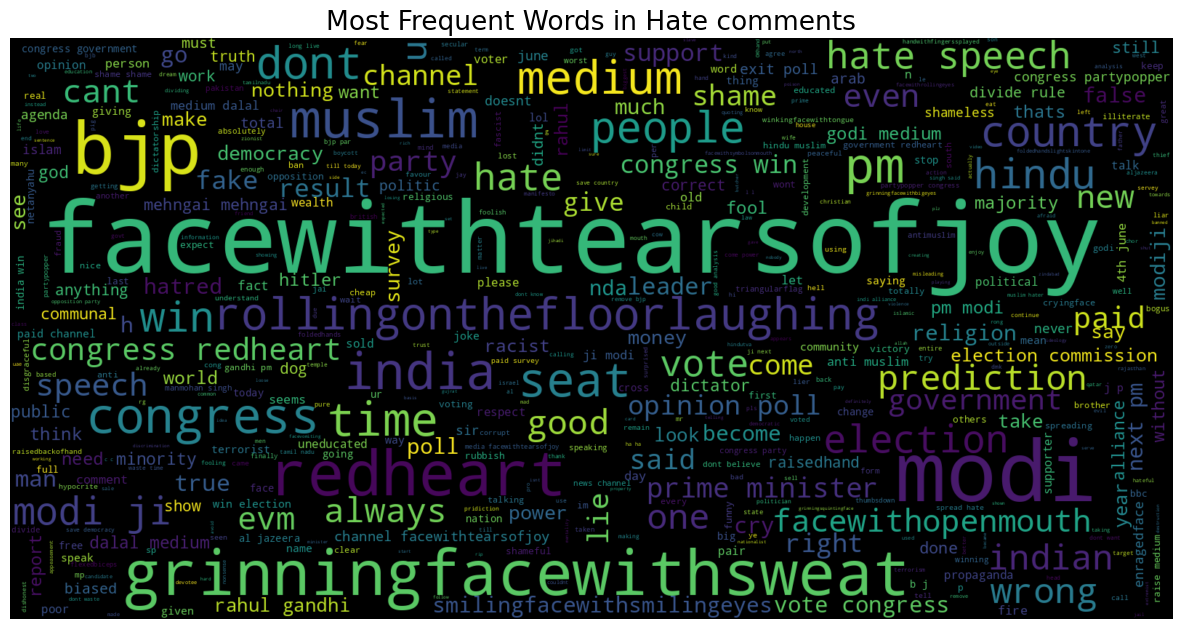

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Filter non-hate tweets
hate = df[df.label == 'hate']

# Join all non-hate tweet texts into a single string, ensuring only strings are included
text = ' '.join([str(word) for word in hate['text'] if isinstance(word, str)])

# Generate the word cloud
plt.figure(figsize=(15, 15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Hate comments', fontsize=19)
plt.show()


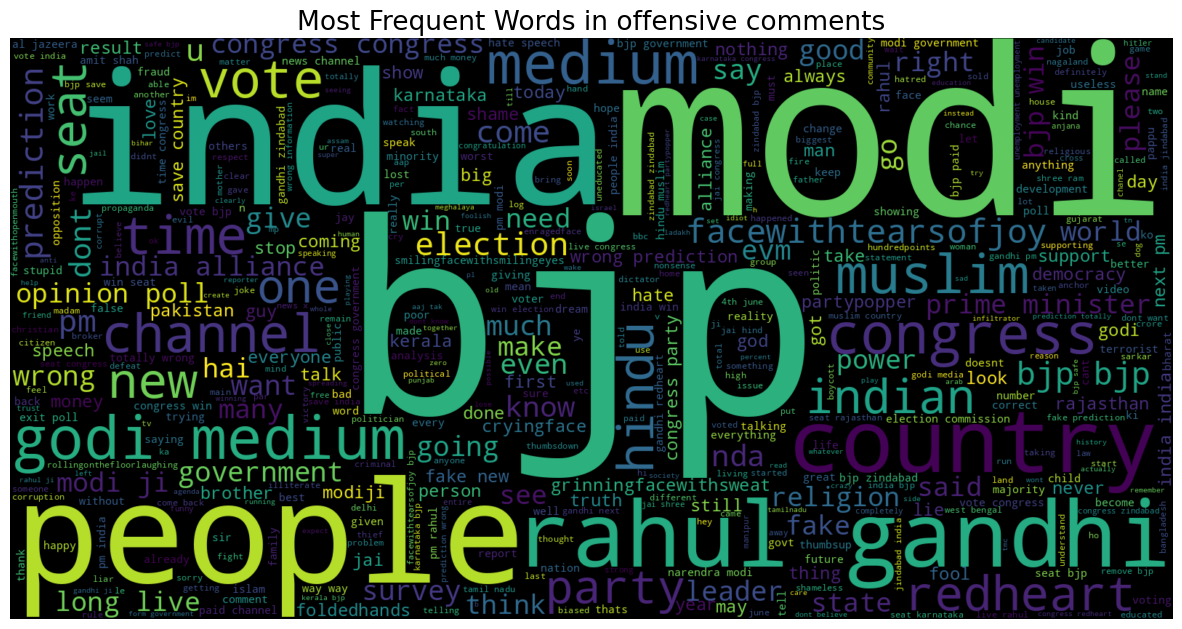

In [ ]:
# Filter non-hate tweets
hate = df[df.label == 'offensive']

# Join all non-hate tweet texts into a single string, ensuring only strings are included
text = ' '.join([str(word) for word in hate['text'] if isinstance(word, str)])

# Generate the word cloud
plt.figure(figsize=(15, 15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in offensive comments', fontsize=19)
plt.show()

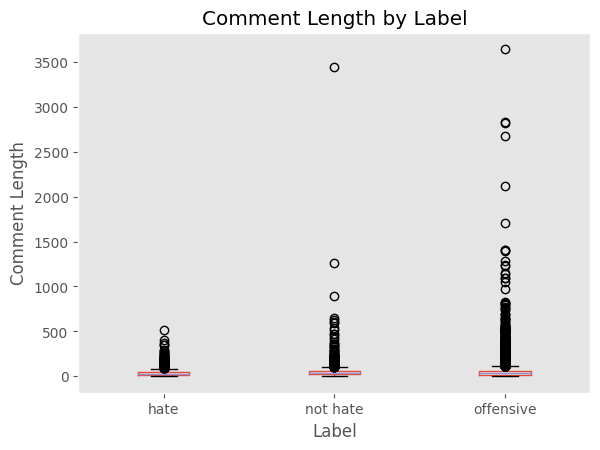

In [ ]:
# Create a new column for comment length, handling non-string values
df['comment_length'] = df['text'].apply(lambda x: len(x) if isinstance(x, str) else 0)

# Create the boxplot
df.boxplot(column='comment_length', by='label', grid=False)
plt.title("Comment Length by Label")
plt.suptitle("")  # Suppress the default title
plt.xlabel("Label")
plt.ylabel("Comment Length")
plt.show()


In [ ]:
df.isna().sum()

,0
text,0
label,0
comment_length,0


In [ ]:
df = df.dropna(subset=['text'])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Filter hate comments
hate_comments = df[df['label'] == 'hate']['text']
# Filter non-hate comments
non_hate_comments = df[df['label'] == 'not hate']['text']

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(2, 2), max_features=50, stop_words='english')

# Fit and transform the hate comments
tfidf_hate = tfidf_vectorizer.fit_transform(hate_comments)
ngram_features_hate = tfidf_vectorizer.get_feature_names_out()
tfidf_hate_array = tfidf_hate.toarray()

# Fit and transform the non-hate comments
tfidf_vectorizer_non_hate = TfidfVectorizer(ngram_range=(2, 2), max_features=50, stop_words='english')
tfidf_non_hate = tfidf_vectorizer_non_hate.fit_transform(non_hate_comments)
ngram_features_non_hate = tfidf_vectorizer_non_hate.get_feature_names_out()
tfidf_non_hate_array = tfidf_non_hate.toarray()

# Display the results
print("Top bigram features in hate comments:")
print(ngram_features_hate)

print("\nTop bigram features in non-hate comments:")
print(ngram_features_non_hate)




Top bigram features in hate comments:
['10 year' '400 pair' '4th june' 'al jazeera' 'anti muslim'
 'bjp facewithtearsofjoy' 'channel facewithtearsofjoy'
 'congress government' 'congress party' 'congress partypopper'
 'congress redheart' 'congress win' 'dalal medium' 'divide rule'
 'dont believe' 'election commission' 'exit poll' 'facewithtearsofjoy bjp'
 'facewithtearsofjoy grinningfacewithsweat' 'gandhi pm' 'godi medium'
 'government redheart' 'grinningfacewithsweat facewithtearsofjoy'
 'hate speech' 'hindu muslim' 'india win' 'ji modi' 'ji pm' 'ji redheart'
 'look like' 'media facewithtearsofjoy' 'medium dalal' 'mehngai mehngai'
 'modi facewithtearsofjoy' 'modi ji' 'news channel' 'opinion poll'
 'paid channel' 'paid survey' 'pm modi' 'pm redheart'
 'poll facewithtearsofjoy' 'prime minister' 'rahul gandhi' 'raise medium'
 'shame shame' 'spread hate' 'time congress' 'vote congress'
 'win election']

Top bigram features in non-hate comments:
['10 year' '400 paar' '400 pair' '400 par' '4

In [ ]:
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 4.0 MB/s eta 0:00:00


In [ ]:
from sentence_transformers import SentenceTransformer
# Load pre-trained SBERT model (you can choose a lightweight version for faster processing)
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Generate embeddings for the 'text' column in your dataset
embeddings = model.encode(df['text'].tolist())
X = np.array(embeddings)
y = df['label']

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
X

array([[ 0.21561304,  0.5142999 , -0.5418476 , ..., -0.10863312,
         0.09535971,  0.06029743],
       [-0.13157195,  0.65892947, -0.2390252 , ..., -0.4679109 ,
         0.48584667,  0.40475985],
       [ 0.21656428, -0.24533904,  0.47015086, ..., -0.30154487,
         0.32211116,  0.70797783],
       ...,
       [-0.09395336, -0.63334215, -0.17986815, ...,  0.33250198,
         0.41714367, -1.0593913 ],
       [ 0.6163473 , -0.2519446 , -0.4938169 , ...,  0.23797993,
         0.24358216, -0.68332714],
       [-0.12613273,  0.0585258 ,  0.44062734, ...,  0.2409228 ,
        -0.20913738, -0.14772789]], dtype=float32)

In [ ]:
# Map 'not hate' to 0 and 'hate' to 1
df['label'] = df['label'].map({'not hate': 0, 'hate': 1,'offensive':2})

In [ ]:
y=df['label']

In [ ]:
y.head()

,label
0,2
1,2
2,0
3,2
4,2


In [ ]:

from imblearn.over_sampling import SMOTE

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an instance of SMOTE
smote = SMOTE(random_state=42)

# Fit and resample
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Check the new class distribution
print(pd.Series(y_resampled).value_counts())

label
2    11998
0    11998
1    11998
Name: count, dtype: int64


In [ ]:
# Initialize and train a classifier (Random Forest in this case)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_resampled, y_resampled)

RandomForestClassifier()

In [ ]:
# Step 4: Evaluate the model
y_pred_1 = model.predict(X_test)
print(confusion_matrix(y_test, y_pred_1))
print(classification_report(y_test, y_pred_1))

[[ 233   55  354]
 [  35  250  350]
 [ 184  156 2668]]
              precision    recall  f1-score   support

           0       0.52      0.36      0.43       642
           1       0.54      0.39      0.46       635
           2       0.79      0.89      0.84      3008

    accuracy                           0.74      4285
   macro avg       0.62      0.55      0.57      4285
weighted avg       0.71      0.74      0.72      4285



In [ ]:
lg = LogisticRegression()
lg.fit(X_resampled, y_resampled)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Evaluate the model
y_pred = lg.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[3546  406]
 [  72  261]]
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      3952
           1       0.39      0.78      0.52       333

    accuracy                           0.89      4285
   macro avg       0.69      0.84      0.73      4285
weighted avg       0.93      0.89      0.90      4285



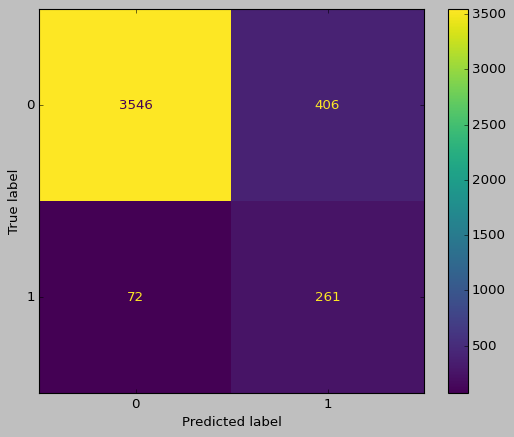

In [ ]:
style.use('classic')
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [ ]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Regularization type
    'C': [0.01, 0.1, 1, 10, 100],                   # Inverse of regularization strength
    'solver': ['saga', 'liblinear'],                # Solvers supporting 'l1', 'l2', and 'elasticnet'
    'class_weight': ['balanced', None]              # Adjusting for class imbalance
}


In [ ]:
# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_resampled, y_resampled)

# Get the best parameters and estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best Parameters: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}


In [ ]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[3556  396]
 [  71  262]]


              precision    recall  f1-score   support

           0       0.98      0.90      0.94      3952
           1       0.40      0.79      0.53       333

    accuracy                           0.89      4285
   macro avg       0.69      0.84      0.73      4285
weighted avg       0.94      0.89      0.91      4285



In [ ]:
len(y_test)

4285